In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.sparse import dia_matrix
import pandas as pd

np.set_printoptions(suppress=True)

# Er3+ effective 1/2

In [2]:
# mu_B = 13996245042         # Bohr magneton in Hz/T
# mu_N = 7622591.4           # Nuclear magneton in Hz/T

h    = 6.6260693e-34       # Plank constant
mu_0 = 12.566370614e-7     # Vacuum permeability

mu_B = 9.27401007831e-24   # Bohr magneton in J/T

mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.1177847*2         # g nuclear 183W
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

mu_93Nb = 10.4213 * 1e6    # [Hz / T]
mu_I = mu_93Nb * h         # 93Nb  in J/T
g_N = mu_I / mu_N          # g nuclear 93Nb

g_perp, g_par = -8.38, -1.247  # g electronic Er
g_a, g_b, g_c = g_perp, g_perp, g_par

W_pos = np.loadtxt('positions_ErW_CaWO4.txt') * 1e-10 # Tungsten atom positions in Amstrongs
n_W_pos = len(W_pos)

FileNotFoundError: positions_ErW_CaWO4.txt not found.

In [30]:
#define the electron-spin operators in the 2 dimensional basis
S = 1/2
mS = np.arange(S, -S-1, -1)
nS = len(mS)
S_plus = dia_matrix((np.sqrt(S*(S+1)-mS*(mS+1)),1), shape = (nS, nS)).toarray()
S_minus = np.transpose(S_plus)
Sx = 0.5*(S_plus+S_minus)     
Sy = -0.5*1j*(S_plus-S_minus)
Sz = dia_matrix((mS,0), shape = (nS, nS)).toarray()


#define the nuclear spin operators in the 8 dimensional basis
I = 9/2
mI = np.arange(I, -I-1, -1)
nI = len(mI)
I_plus = dia_matrix((np.sqrt(I*(I+1)-mI*(mI+1)),1), shape = (nI, nI)).toarray()
I_minus = np.transpose(I_plus)
Ix = 0.5*(I_plus+I_minus)     
Iy = -0.5*1j*(I_plus-I_minus)
Iz = dia_matrix((mI,0), shape = (nI, nI)).toarray()

[[-440.37044171    0.           -0.        ]
 [   0.         -440.37044171   -0.        ]
 [  -0.           -0.          131.06012907]]


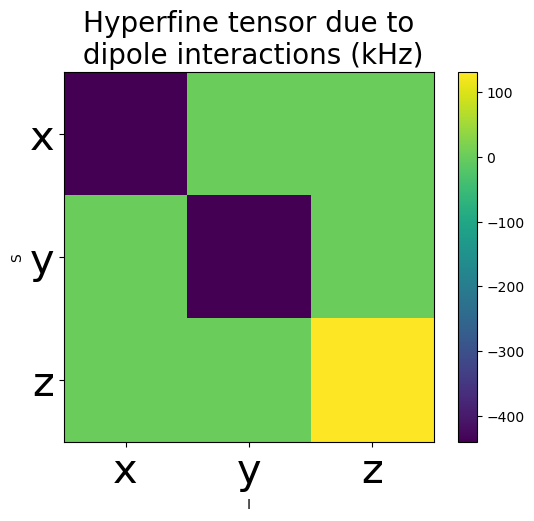

In [31]:
def get_hyperfine_tensor(xyz):
    """
    Calculates the hyperfine tensor and hamiltonian due to the dipole-dipole interaction between two spins
    The expression for the hyperfine tensor used is detailed in Le Dantec's Thesis (2022), p36
 
    --------------------------------------------------------------------------------------------------------------
    
        - xyz (np.array): Cartesian coordinates of the nuclear spin
        - B (np.array): External magnetic field applied to the system
        - return_xyz_tensor (bool): return the tensor and hamiltonian on the original basis (True) 
                                    or in the rotated basis (z' along B) (False)
        
    --------------------------------------------------------------------------------------------------------------
    
        - Tdd (np.array): hyperfine coupling tensor
        - Hdd (np.array): hamiltonian of interaction
        
    """
    
    x, y, z = xyz
    r = np.linalg.norm(xyz)
    
    Tdd = np.zeros((3, 3)) # dipole-dipole tensor
    prefactor = g_N * r**-5 * mu_B * mu_N * mu_0/(4*np.pi)

    # diagonal
    Tdd[0,0] = g_a * (r**2 - 3*x**2)
    Tdd[1,1] = g_b * (r**2 - 3*y**2)
    Tdd[2,2] = g_c * (r**2 - 3*z**2)
    
    # xy
    Tdd[0,1] = g_a * (-3)*x*y
    Tdd[1,0] = g_b * (-3)*y*x
    
    # xz
    Tdd[0,2] = g_a * (-3)*x*z
    Tdd[2,0] = g_c * (-3)*z*x
    
    # yz
    Tdd[1,2] = g_b * (-3)*y*z
    Tdd[2,1] = g_c * (-3)*z*y
    
    Tdd *= prefactor
    
    Hdd = (
        Tdd[0,0] * np.kron(Sx, Ix) + Tdd[1,1] * np.kron(Sy, Iy) + Tdd[2,2] * np.kron(Sz, Iz) + 
        Tdd[0,1] * np.kron(Sx, Iy) + Tdd[1,0] * np.kron(Sy, Ix) +
        Tdd[0,2] * np.kron(Sx, Iz) + Tdd[2,0] * np.kron(Sz, Ix) +
        Tdd[1,2] * np.kron(Sy, Iz) + Tdd[2,1] * np.kron(Sz, Iy)
    )
    return Tdd, Hdd

hyperfine_tensor, h_dipole = get_hyperfine_tensor(W_pos[8,1:])
plt.figure()
plt.imshow(hyperfine_tensor/h*1e-3)
plt.colorbar()
plt.title("Hyperfine tensor due to\n dipole interactions (kHz)", fontsize=20)
plt.xticks([0, 1, 2], ["x", "y", "z"], fontsize=30)
plt.xlabel('I')
plt.ylabel('S')
plt.yticks([0, 1, 2], ["x", "y", "z"], fontsize=30)
print(hyperfine_tensor/h*1e-3)

In [23]:
def get_new_eigenstates(w_pos, B_field):
        
    # Calculate the Zeeman hamiltonians and find their respective unitary rotations for diagonalization
    h_Zeeman_spin = mu_B * (B_field[0]*g_a*Sx + B_field[1]*g_b*Sy + B_field[2]*g_c*Sz)
    h_Zeeman_nucl = - mu_N * g_N * (B_field[0]*Ix + B_field[1]*Iy + B_field[2]*Iz)

    _, rotmat_spin = np.linalg.eigh(h_Zeeman_spin)
    _, rotmat_nucl = np.linalg.eigh(h_Zeeman_nucl)

    # Calculate the general rotation matrix
    rotmat = np.kron(np.identity(nS), rotmat_nucl) @ np.kron(rotmat_spin, np.identity(nI))
    return rotmat

def get_hyperfine_constants(w_pos, B_field):
    """
    Given a tugnsten ion and a magnetic field calculate the constants A and B from the secular approximation.
    This needs testing when the magnetic field is applied in the y direction
    
    --------------------------------------------------------------------------------------------------------------
    
        - B (np.array): External magnetic field applied to the system
        
    --------------------------------------------------------------------------------------------------------------
    
        - a (float): coupling constant along Sz'Iz
        - b (float): coupling constant along Sz'Ix
        
    """

    rotmat = get_new_eigenstates(w_pos, B_field)
    # Obtain the dipole-dipole hamiltonian for the given ion and rotate it to the new frame
    _, h_dipole = get_hyperfine_tensor(w_pos)
    rot_h_dipole = rotmat.T.conj() @ h_dipole @ rotmat
    
    # Through the secular approximation obtain the constants a and b
    a = np.real(rot_h_dipole[0,0])/h*1e-3 / (S * I)
    b = abs(rot_h_dipole[0,1])/h*1e-3 / (S * I)
    print(np.angle(rot_h_dipole[0,1])* 180 / np.pi)  
    return a, b

In [24]:
# Parametric sweep of the magnetic field
angles = 0.57 * np.pi/180
B0 = 0.400
gamma = -0.57 * np.pi/180
B_fields = B0*np.array([np.sin(gamma) + 0*angles, np.cos(gamma)*np.sin(angles), np.cos(gamma)*np.cos(angles)])
# W ion to calculate the constants
i_w_pos = 9
w_pos = W_pos[i_w_pos, 1:]

A, B = get_hyperfine_constants(w_pos, B_fields)
print(f"A_v1 = {A:.2f} kHz, B_v1 = {B:.2f} kHz")

-2.7267606024639266e-15
A_v1 = 22.38 kHz, B_v1 = 7.46 kHz


-180.0
180.0
180.0
180.0
-180.0
180.0
-180.0
180.0
-180.0
-180.0
4.476274013013812e-15
180.0
180.0
180.0
-180.0
-180.0
-180.0
180.0
180.0
-180.0
180.0
1.5630736360903199e-15
-180.0
1.7825076981937232e-14
-180.0
180.0
-180.0
-6.20271366860968e-15
180.0
-180.0
-180.0
-3.168510461641219e-15
-180.0
180.0
180.0
180.0
180.0
180.0
-180.0
-180.0
-180.0
4.160895080353357e-15
180.0
180.0
180.0
-3.973140981453329e-15
-180.0
-180.0
-2.9686663956358255e-15
1.2095525997361057e-16
179.99999999999997
180.0
-180.0
-180.0
180.0
180.0
-3.7153525054888116e-15
-1.4139100299131252e-14
-180.0
-180.0
-180.0
-180.0
180.0
180.0
-180.0
-180.0
-1.94806701946438e-14
-180.0
-180.0
-180.0
180.0
-179.99999999999997
-180.0
180.0
180.0
-180.0
-180.0
180.0
-180.0
-180.0
-180.0
180.0
180.0
180.0
-180.0
180.0
-180.0
-180.0
180.0
-180.0
180.0
180.0
-180.0
180.0
-180.0
-180.0
1.023099480625855e-15
-180.0
180.0
-180.0
-180.0
-4.9887591393467194e-15
180.0
-180.0
180.0
-180.0
-180.0
180.0
-180.0
-180.0
-180.0
180.0
-180.0
180.

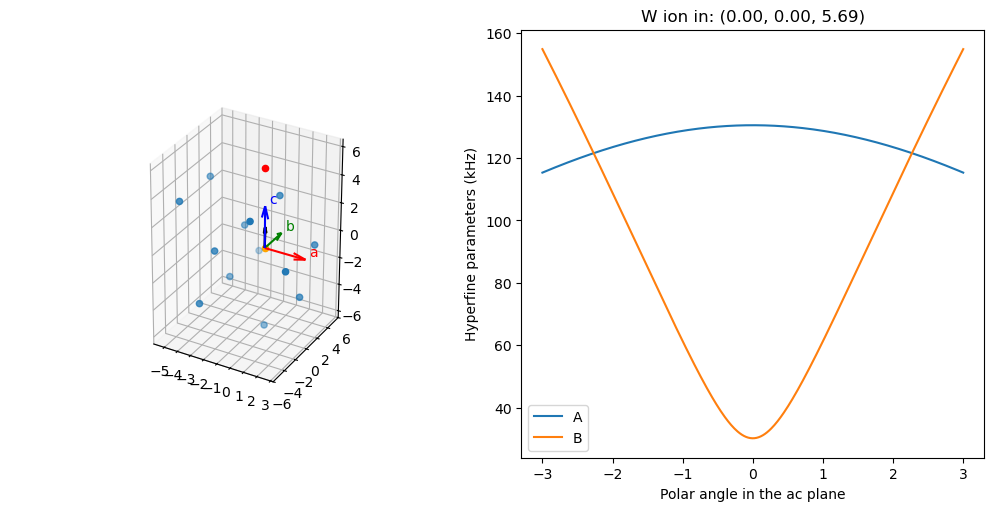

In [28]:
# Parametric sweep of the magnetic field
n_angles = 400
angles = np.linspace(-np.pi/60, np.pi/60, n_angles)

# Parametrize the angles to have a missalignment with the c axis
gamma = 0.56 * np.pi/180
B0 = 0.4
B_fields = B0*np.array([np.sin(gamma) + 0*angles, np.cos(gamma)*np.sin(angles), np.cos(gamma)*np.cos(angles)])

"""
# Parameters of the magnetic field in spherical coordinates
B0 = 0.2
theta = 0.8 * np.pi/180
phi = angles
B_fields = B0*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)+0*angles])
"""

# W ion to calculate the constants
i_w_pos = 9
w_pos = W_pos[i_w_pos, 1:]

A_hyperfine, B_hyperfine = np.zeros(n_angles), np.zeros(n_angles) 
for i in range(n_angles):
    A_hyperfine[i], B_hyperfine[i] = get_hyperfine_constants(w_pos, B_fields[:,i])

fig = plt.figure(figsize=(10,5),constrained_layout=True)

# # # # # #
# 2D plot #
# # # # # #

ax = fig.add_subplot(1, 2, 2)
ax.plot(angles*180/np.pi, A_hyperfine, label="A")
ax.plot(angles*180/np.pi, B_hyperfine, label="B")
ax.set(
    title = "W ion in: (%.2f, %.2f, %.2f)"%tuple(w_pos*1e10),
    xlabel = "Polar angle in the ac plane",
    ylabel = "Hyperfine parameters (kHz)"
)
ax.legend()

if False:
    lab_By = 56
    lab_Bz = 170
    lab_theta = np.arctan2(lab_By, lab_Bz)
    ax.vlines(lab_theta*180/np.pi, -10, max(max(A_hyperfine), max(B_hyperfine)), 'k')

# # # # # #
# 3D plot #
# # # # # #

ax3d = fig.add_subplot(1, 2, 1, projection='3d')
i_W_to_plot = max(10, i_w_pos + 5)
x, y, z = np.transpose([W_pos[i, 1:]*1e10 for i in range(i_W_to_plot) if i != i_w_pos])
x_fig, y_fig, z_fig = W_pos[i_w_pos, 1:].T * 1e10

ax3d.scatter3D(x, y, z)
ax3d.scatter3D(0, 0, 0, color='orange')
ax3d.scatter3D(x_fig, y_fig, z_fig, color='red')

u, v, w, c, t = [3,0,0], [0,3,0],[0,0,3],['r','g','b'],['a','b','c']
for i in range(3):
    ax3d.quiver(0, 0, 0, u[i], v[i], w[i], color=c[i])
    ax3d.text(u[i]+0.2, v[i]+0.2, w[i]+0.2, t[i], color=c[i])
    
for i in range(7+1):
    j = i*(n_angles-1)//7
    Bx,By,Bz = B_fields[:, j]/B0*1.5
    ax3d.quiver(0, 0, 0, Bx, By, Bz, color='k', alpha=0.4)

x_scale=1
y_scale=1
z_scale=2
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
def short_proj():
  return np.dot(Axes3D.get_proj(ax3d), scale)
ax3d.get_proj=short_proj


In [26]:
def get_A_and_B_range(ion_indices, angle_0, angle_1, n_angles = 400):
    # Parametric sweep of the magnetic field
    angles = np.linspace(angle_0 * np.pi/180, angle_1 * np.pi/180, n_angles)

    # Parametrize the angles to have a missalignment with the c axis
    gamma = 0.8 * np.pi/180
    B0 = 0.441
    B_fields = B0*np.array([np.sin(gamma) + 0*angles, np.cos(gamma)*np.sin(angles), np.cos(gamma)*np.cos(angles)])

    # W ion to calculate the constants
    i_w_pos = 0
    A_list = []
    B_list = []
    for i_w_pos in ion_indices:

        w_pos = W_pos[i_w_pos, 1:]

        for i in range(n_angles):
            A, B = get_hyperfine_constants(w_pos, B_fields[:,i])
            A_list.append(A)
            B_list.append(B)
    
    A_list = np.abs(A_list)
    A_range = [np.max(A_list), np.min(A_list)]

    B_list = np.abs(B_list)
    B_range = [np.max(B_list), np.min(B_list)]
    return A_range, B_range


typeI   = [0, 1, 2, 3]
anglesI = [-0.2, 0.1]
A_range, B_range = get_A_and_B_range(typeI, anglesI[0], anglesI[1])
print('Type I range\nA: ', A_range, 'kHz \nB: ', B_range, ' kHz\n')

typeII  = [4, 5, 6, 7]
anglesII = [-0.201, -0.2]
A_range, B_range = get_A_and_B_range(typeII, anglesII[0], anglesII[1])
print('Type II range\nA: ', A_range, 'kHz \nB: ', B_range, ' kHz\n')

typeIII = [8, 9]
anglesIII = [-0.3, -0.1]
A_range, B_range = get_A_and_B_range(typeIII, anglesIII[0], anglesIII[1])
print('Type III range\nA: ', A_range, 'kHz \nB: ', B_range, ' kHz')



-97.9008573556495
-97.79408121674041
-97.68733479383884
-97.5806181862064
-97.47393149283928
-97.36727481246933
-97.26064824356486
-97.15405188433168
-97.04748583271393
-96.94095018639521
83.16555495720071
-96.72797049909123
-96.62152665217819
83.48488640128953
-96.40873143508244
-96.30238025743344
-96.19606016164875
-96.08977124336052
-95.98351359794871
-95.87728732054207
-95.7710925060191
-95.66492924900892
-95.55879764389219
84.54730221519779
-95.34662976562575
-95.24059368000398
84.86541037866654
-95.0286176827671
-94.92267795721501
-94.81677053734558
-94.71089551558626
-94.60505298412465
-94.49924303490937
-94.39346575965097
-94.28772124982291
-94.18200959666255
-94.07633089117193
86.02931477588112
-93.8650726860378
86.24050663276921
86.34605264223167
-93.5484347474904
-93.44295562600735
86.66248991729918
-93.23209820672466
-93.12672008700585
86.97862418775446
-92.91606547091976
-92.81078915128052
-92.70554694135659
-92.60033892895457
-92.49516520165965
-92.39002584683662
-92.2849

70.81805401267067
70.8179456447764
70.81783782136753
70.81773054244519
70.81762380801057
70.8175176180648
70.81741197260905
70.81730687164442
70.81720231517208
70.81709830319313
70.81699483570874
70.81689191271998
70.81678953422795
70.81668770023381
70.81658641073861
70.81648566574346
70.81638546524943
70.81628580925764
70.81618669776913
70.81608813078498
70.81599010830624
70.81589263033399
70.81579569686926
70.81569930791309
70.81560346346657
70.81550816353068
70.81541340810648
70.81531919719497
70.81522553079716
70.81513240891411
70.81503983154674
70.81494779869612
70.81485631036323
70.81476536654903
70.8146749672545
70.81458511248064
70.81449580222841
70.81440703649876
70.8143188152927
70.81423113861109
70.81414400645494
70.81405741882516
70.81397137572272
70.81388587714851
70.81380092310347
70.8137165135885
70.81363264860454
70.81354932815245
70.81346655223315
70.81338432084756
70.81330263399651
70.81322149168095
70.81314089390168
70.81306084065963
70.81298133195563
70.812902367790

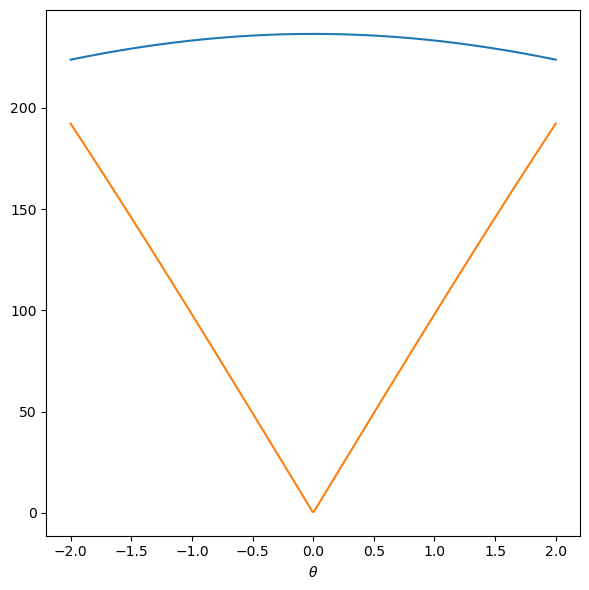

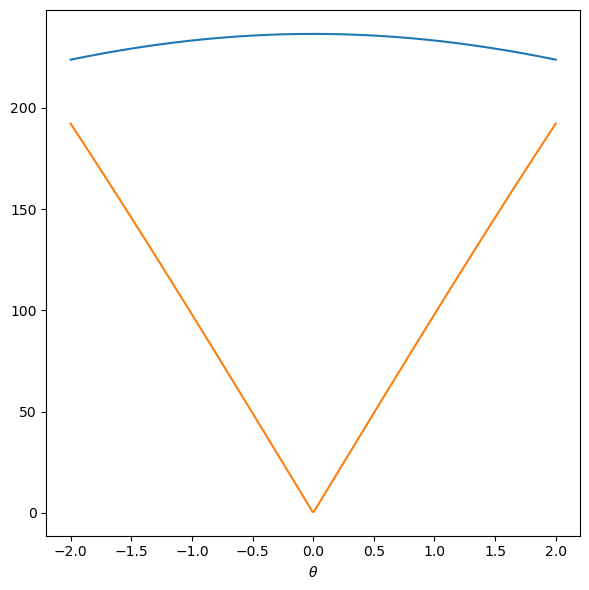

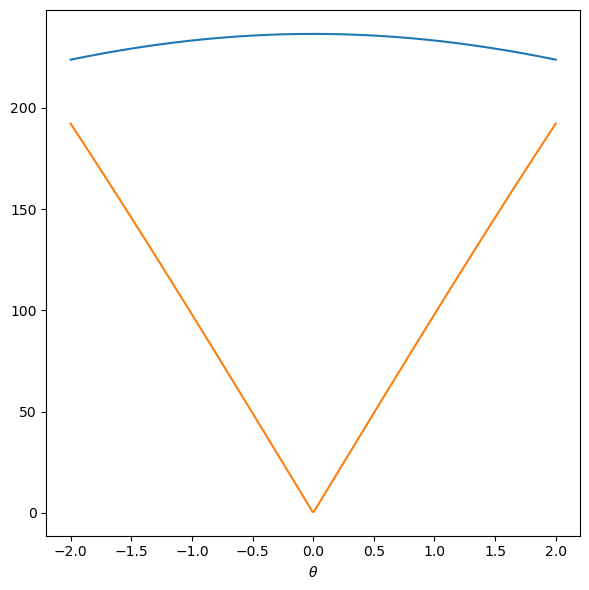

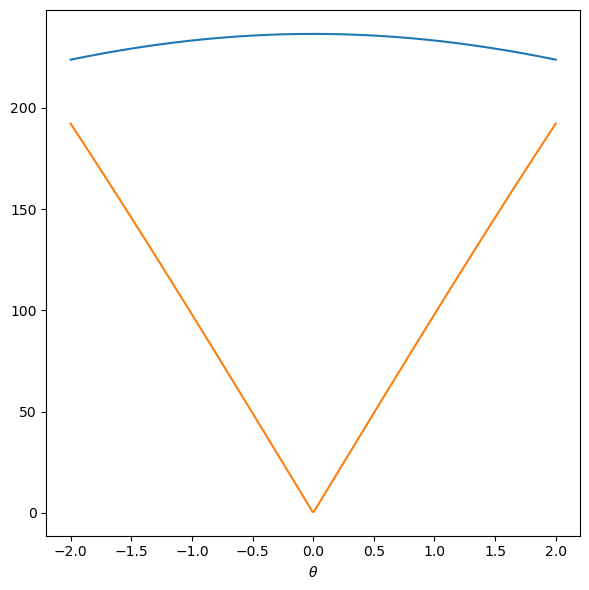

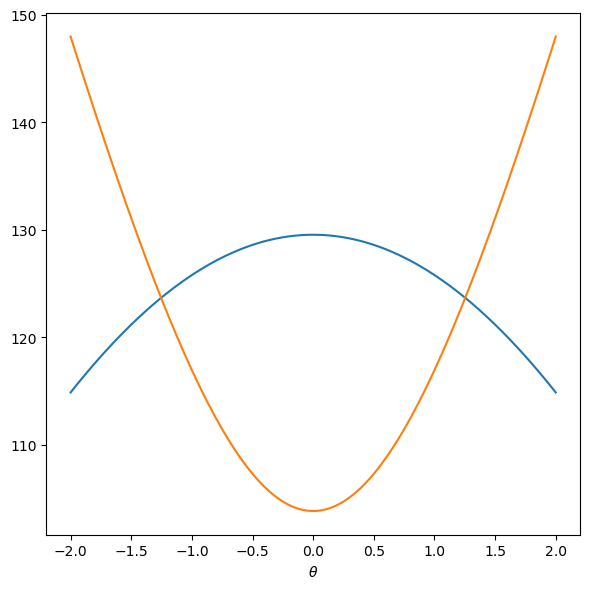

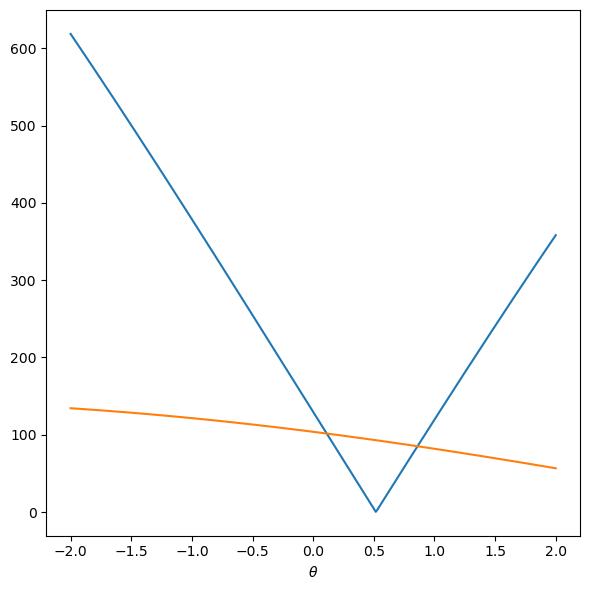

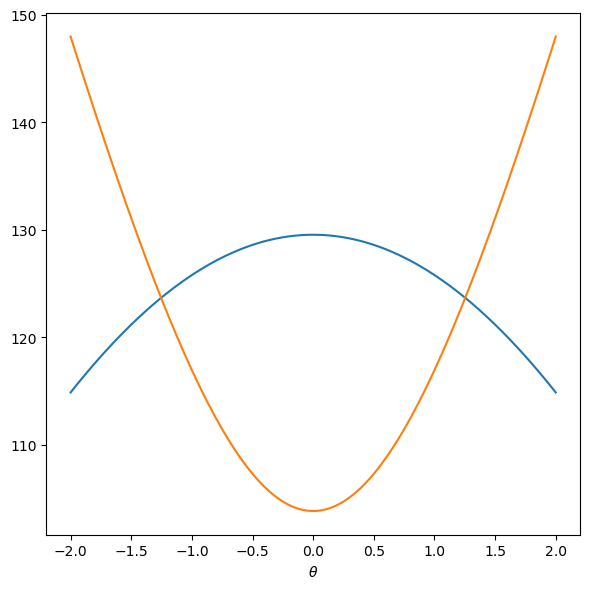

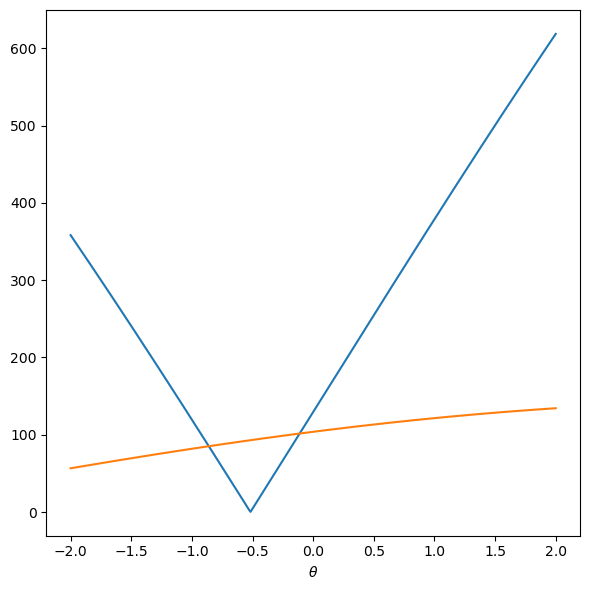

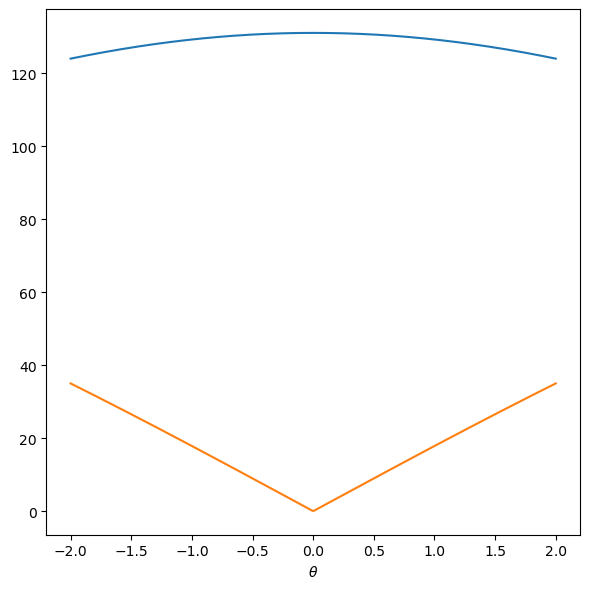

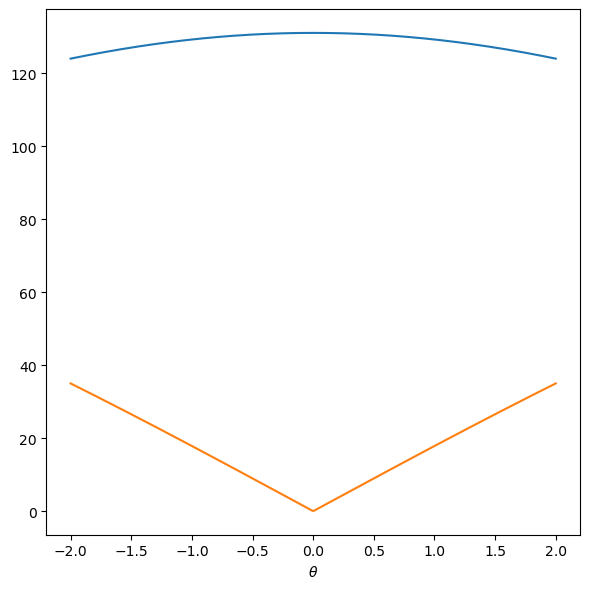

In [16]:
"""
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.size'] = 35
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4
"""

# Parametric sweep of the magnetic field
n_angles = 400
angles = np.linspace(-2 * np.pi/180, 2 * np.pi/180, n_angles)

# Parametrize the angles to have a missalignment with the c axis
gamma = 0 * np.pi/180
B0 = 0.441
B_fields = B0*np.array([np.sin(gamma) + 0*angles, np.cos(gamma)*np.sin(angles), np.cos(gamma)*np.cos(angles)])

# W ion to calculate the constants
i_w_pos = 0
for i_w_pos in range(0, 10):

    w_pos = W_pos[i_w_pos, 1:]

    A_hyperfine, B_hyperfine = np.zeros(n_angles), np.zeros(n_angles) 
    for i in range(n_angles):
        A_hyperfine[i], B_hyperfine[i] = get_hyperfine_constants(w_pos, B_fields[:,i])

    fig = plt.figure(figsize=(6,6), tight_layout=True)

    # # # # # #
    # 2D plot #
    # # # # # #

    plt.plot(angles*180/np.pi, abs(A_hyperfine), label="A")
    plt.plot(angles*180/np.pi, abs(B_hyperfine), label="B")

    
    #plt.plot(thetas, As, '.', ms=20, color='tab:blue')
    #plt.plot(thetas, Bs, '.', ms=20, color='tab:orange')
    #plt.ylim(-50, 100)
    plt.gca().set(
        #title = "W ion in: (%.2f, %.2f, %.2f)"%tuple(w_pos*1e10),
        xlabel = r"$\theta$",
        #ylabel = "Hyperfine (kHz)"
    )
    
    #plt.legend()
    #plt.savefig(f'figures/hyperfine_ion_{i_w_pos}.pdf', bbox_inches='tight')

[-0.263, -0.213, -0.088, -0.088, 0.087]


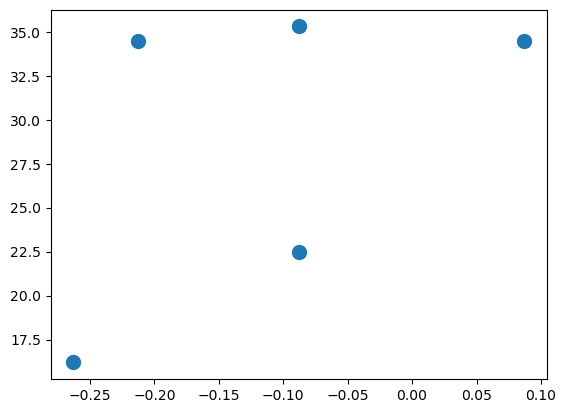

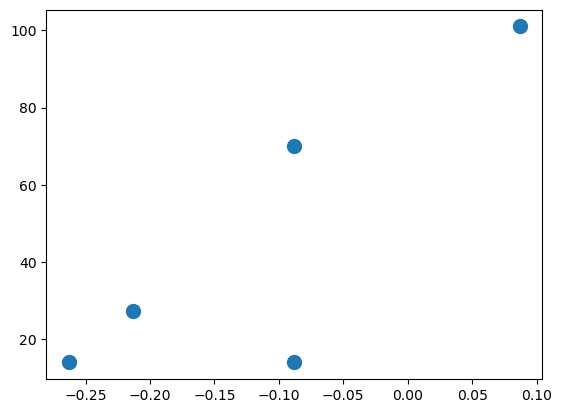

In [10]:
## Known values of the hyperfine along with angles

theta0 = -0.093

theta1 = -0.17 + theta0
A1 = 16.2
B1 = 14.0

theta2 = -0.12 + theta0
A2 = 34.5
B2 = 27.2

theta3 = 0.005 + theta0
A3 = 35.3
B3 = 70

theta4 = 0.005 + theta0
A4 = 22.5
B4 = 14

theta5 = 0.18 + theta0
A5 = 34.5
B5 = 101


thetas = [theta1, theta2, theta3, theta4, theta5]
As = [A1, A2, A3, A4, A5]
Bs = [B1, B2, B3, B4, B5]

print(thetas)
plt.figure()
plt.plot(thetas, As, '.', ms=20)
plt.figure()
plt.plot(thetas, Bs, '.', ms=20)

[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [ 0.+

<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
/var/folders/cc/gch5f6gx5716gr3vpg1glxkm0000gn/T/ipykernel_57195/474821059.py:48: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(angles*180/np.pi, A_hyperfine, label=f"$A_\parallel$")
/var/folders/cc/gch5f6gx5716gr3vpg1glxkm0000gn/T/ipykernel_57195/474821059.py:49: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(angles*180/np.pi, B_hyperfine, label=f"$A_\perp$")


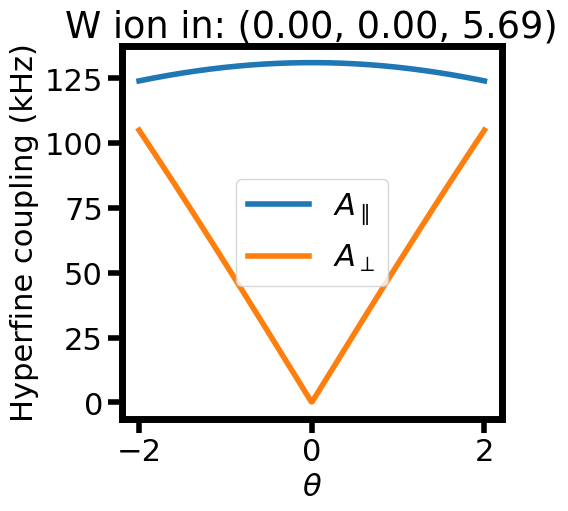

In [11]:
# Hyperfine with strain

def generate_strain(strain, samples=1000):
    return 2*(np.random.random([3, samples])-0.5) * strain

plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 4

# Parametric sweep of the magnetic field
n_angles = 400
angles = np.linspace(-2 * np.pi/180, 2 * np.pi/180, n_angles)

# Parameters of the magnetic field
B0 = 0.441
theta = angles
phi = 0
B_fields = B0*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)+0*angles])

# W ion to calculate the constants
i_w_pos = 9
w_pos = W_pos[i_w_pos, 1:]

A_hyperfine, B_hyperfine = np.zeros(n_angles), np.zeros(n_angles) 
for i in range(n_angles):
    A_hyperfine[i], B_hyperfine[i] = get_hyperfine_constants(w_pos, B_fields[:,i])

fig = plt.figure(figsize=(5,5),constrained_layout=True)

# # # # # #
# 2D plot #
# # # # # #

all_strain = []
for i in range(1):
    A_hyperfine, B_hyperfine = np.zeros(n_angles), np.zeros(n_angles) 
    strain = 0*np.random.random(3) * 10e-2 * w_pos.mean() # Percentage error 
    for i in range(n_angles):
        A_hyperfine[i], B_hyperfine[i] = get_hyperfine_constants(w_pos + strain, B_fields[:,i])
    plt.plot(angles*180/np.pi, A_hyperfine, alpha=0.01, color='blue')
    plt.plot(angles*180/np.pi, B_hyperfine, alpha=0.01, color='orange')
    all_strain.append(strain)

plt.plot(angles*180/np.pi, A_hyperfine, label=f"$A_\parallel$")
plt.plot(angles*180/np.pi, B_hyperfine, label=f"$A_\perp$")
plt.gca().set(
    title = "W ion in: (%.2f, %.2f, %.2f)"%tuple(w_pos*1e10),
    xlabel = r"$\theta$",
    ylabel = "Hyperfine coupling (kHz)"
)
plt.legend()

plt.savefig(f'figures/hyperfine_ion_{i_w_pos}.pdf', bbox_inches='tight')

In [12]:
w_pos*(1+strain)*1e9

array([0.      , 0.      , 0.568685])

In [13]:
# Parameters of the magnetic field
B0 = 0.455
theta = 0*np.pi/180
phi = 0*np.pi/180
B_field = [B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)]

n_W_max = 20

save_results = True

A_hyperfine, B_hyperfine = np.zeros(n_W_max), np.zeros(n_W_max) 
for i in range(n_W_max):
    A_hyperfine[i], B_hyperfine[i] = get_hyperfine_constants(W_pos[i, 1:], B_field)


df = pd.DataFrame({
 "x (Ams)": np.round(W_pos[:n_W_max, 1]*1e10, 2),
 "y (Ams)": np.round(W_pos[:n_W_max, 2]*1e10, 2),
 "z (Ams)": np.round(W_pos[:n_W_max, 3]*1e10, 2),
 "A (kHz)": np.round(A_hyperfine, 2),
 "B (kHz)": np.round(B_hyperfine, 2),
})

B_str = '(%.1f,%.1f,%.1f)'%(B_field[0]*1e3, B_field[1]*1e3, B_field[2]*1e3)
print("Magnetic field applied: %s mT"%B_str)
print(df.to_string())

if save_results:
    df.to_csv('results/%d_hyperfine_parameters_%s.csv'%(n_W_max, B_str))

[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
[[-0.+0.j  0.+0.j]
 [-0.+0.j  0.+0.j]]
Magnetic field applied: (0.0,0.0,455.0) mT
    x (Ams)  y (Ams)  z (Ams)  A (kHz)  B (kHz)
0     -2.62    -2.62     0.00  -236.53     0.00
1     -2.62     2.62     0.00  -236.53     0.00
2      2.62    -2.62     0.00  -2